In [1]:

import gzip
ident = None
id_to_seq = {}
for i, l in enumerate(gzip.GzipFile("bbn963.isoseq.trimmed.fastq.gz")):
    m = i % 4
    if m == 0:
        ident = l.decode("ascii").strip().replace("@", "").replace(">", "")
    elif m == 1:
        id_to_seq[ident] = l.decode("ascii").strip()
    

In [2]:
len(id_to_seq)

3911660

In [3]:
import pyensembl 

In [4]:
genome = pyensembl.genome_for_reference_name("GRCm39")

In [5]:
ts = {t for t in genome.transcripts() if t.is_protein_coding}

In [6]:
from collections import defaultdict
import progressbar
kmer_index = defaultdict(list)
max_hits = 100
pruned_kmers = set([])
k = 50

print("Indexing kmers")
for t in progressbar.ProgressBar()(ts):
    s = t.sequence    
    for i in range(len(s) - k + 1):
        kmer = s[i:i+k]
        if kmer in pruned_kmers:
            continue
        hits = kmer_index[kmer]
        if len(hits) >= max_hits:
            pruned_kmers.add(kmer)
            continue
        else:
            kmer_index[kmer].append((t, i))
            
print("Pruning highly recurrent kmers")
for kmer in pruned_kmers:
    del kmer_index[kmer]

Indexing kmers


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/iskander/Library/Caches/pyensembl/GRCm39/ensembl109/Mus_musculus.GRCm39.cdna.all.fa.gz.pickle                                              |
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/iskander/Library/Caches/pyensembl/GRCm39/ensembl109/Mus_musculus.GRCm39.ncrna.fa.gz.pickle


Pruning highly recurrent kmers


100% |#########################################################################################################################################################################################################|


In [7]:
match_counts = {}
match_locs = defaultdict(list)
for name, seq in progressbar.ProgressBar()(id_to_seq.items()):
    i = 0
    n = len(seq)
    mismatches = 0
    matches = 0
    while i < ((n//k) * k):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            match_locs[name].append((kmer, kmer_index[kmer]))
            matches += k
            i += k
        else:
            mismatches += 1
            i += 1
    match_counts[name] = (matches, mismatches)

100% |#########################################################################################################################################################################################################|


In [8]:
name_and_percents = [
    (name, y / (y + n))
    for name, (y, n) in match_counts.items()
    if (y + n) > 0 
]
percents = [p for (_, p) in name_and_percents]
import numpy as np 
percents = np.array(percents)

In [9]:
low_matches = [name for (name, p) in name_and_percents if p < 0.005]

In [10]:
len(low_matches)

70103

In [11]:
low_matches

['m64220e_221031_034831/273/ccs',
 'm64220e_221031_034831/553/ccs',
 'm64220e_221031_034831/824/ccs',
 'm64220e_221031_034831/1363/ccs',
 'm64220e_221031_034831/2324/ccs',
 'm64220e_221031_034831/67427/ccs',
 'm64220e_221031_034831/67753/ccs',
 'm64220e_221031_034831/68052/ccs',
 'm64220e_221031_034831/132519/ccs',
 'm64220e_221031_034831/196772/ccs',
 'm64220e_221031_034831/198185/ccs',
 'm64220e_221031_034831/265049/ccs',
 'm64220e_221031_034831/394527/ccs',
 'm64220e_221031_034831/460800/ccs',
 'm64220e_221031_034831/524901/ccs',
 'm64220e_221031_034831/526035/ccs',
 'm64220e_221031_034831/590681/ccs',
 'm64220e_221031_034831/656365/ccs',
 'm64220e_221031_034831/656605/ccs',
 'm64220e_221031_034831/657870/ccs',
 'm64220e_221031_034831/657871/ccs',
 'm64220e_221031_034831/789093/ccs',
 'm64220e_221031_034831/852571/ccs',
 'm64220e_221031_034831/918783/ccs',
 'm64220e_221031_034831/985175/ccs',
 'm64220e_221031_034831/1048963/ccs',
 'm64220e_221031_034831/1050301/ccs',
 'm64220e_22103

In [12]:
id_to_seq["m64220e_221031_034831/26347047/ccs"]

'ATGAGACATGCAGACAATGAGAATATGCAGCAAGCTAGGTGTGATCATGTATATTATCCCCTCACTTGTGAGGCAGAAAAATCATGTGTTTGAGGCCAGCCTGGGCTACATAGGAATACTCTGTTCCCAGAACCAAAACAACAATTATACCCTCCAAATATCTAGTTTTGCAACACGGATGATCAGGATTCAAGTCCTACCTACTATCTCTACTGTCCCAGACAGATTAATATCTAGTTTCCCTTCTCTAAAGCAAACTGTCATATCTAGCTCAGAGGCTATGTGAATGTAACATCCAAAGGGCTCCCTCATGTCCTAACAGCGCCTGGCACGCAATAAGCACATAGGAGGGTAGCTAGTCATAGATCCAGAGAAGTGTGACTCACTACAAATGCAATACAAAGTACCAGCCACTGGAGAAAATGAGTTAAATTTCTAGTAGGCAAACTAAAGAGAATAATGAAAGAGGCTGGGTACTTGGGTATTCTCTGTTTTCCGTGTGATAGTCCCAGTGTGCATGGATATAGCCGTCCACCTTGTCTCCTGTGAATATACCTGCCACGCATTTAATAGGCTTACTCATCAGACTCTTGACCACAGGTTACAGGAGGGAGCAGGAATGTTCATACTTAAGTGTGCCATTGTATCATTTCTCCCTCAACCACAGCATGTAAACAAAGCAAAGCAACACCCCCAGAACTGTCCTTAGCTGCACAGGAAAGATACCTGAAACTGAATTTAAGAAAGTTCAGGGGGAAAAGGTAGAAAGATACAAACTTAGACAGGGTGGTTGTTGTAGTTGTTGTTGGTTTGGTTTTTTTGTTTGTTTGTTTGTTTTGTTTTGTTGTTTTTTTTTTTTACATAGCCTTGACTGGTCTGGAACTCATTATGTATGTAGATCAGGATGGCCTCAAACTTCCAAAGATGCCCCTGCCTCTGCTTCGTAAGTGCTGGGACTAAAAGGCCTTTGCTACCTCACCCAGATTGGAAGATGTGATC

In [13]:
max(low_matches, key= lambda s: len(id_to_seq[s]))

'm64220e_221031_034831/107611501/ccs'

In [14]:
weirdo = id_to_seq["m64220e_221031_034831/107611501/ccs"]

In [15]:
len(weirdo)

9517

In [16]:
import re
[m.start() for m in re.finditer("CCATGG", weirdo)]

[1562, 1682, 2920, 9253, 9284]

In [17]:
np.median(percents)

0.9795918367346939

In [18]:
np.mean(percents > 0.995)

0.39070434618995126

In [19]:
import seaborn

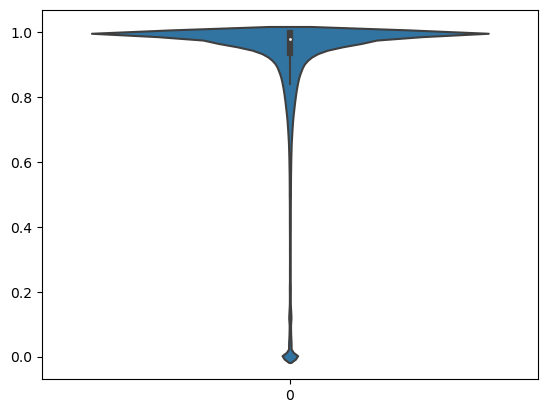

In [20]:
ax = seaborn.violinplot(percents)

In [21]:
ax.figure.savefig('percent-kmer-match-bbn963-k50.png')

In [22]:
np.mean(percents > 0.99)

0.4246101906711633

In [23]:
[(k, (y,n)) for (k, (y, n)) in match_counts.items() if y == 0]

[('m64220e_221031_034831/273/ccs', (0, 2000)),
 ('m64220e_221031_034831/553/ccs', (0, 1600)),
 ('m64220e_221031_034831/824/ccs', (0, 2800)),
 ('m64220e_221031_034831/1363/ccs', (0, 1250)),
 ('m64220e_221031_034831/2324/ccs', (0, 1550)),
 ('m64220e_221031_034831/67427/ccs', (0, 800)),
 ('m64220e_221031_034831/67753/ccs', (0, 1150)),
 ('m64220e_221031_034831/68052/ccs', (0, 2300)),
 ('m64220e_221031_034831/132519/ccs', (0, 2900)),
 ('m64220e_221031_034831/196772/ccs', (0, 3000)),
 ('m64220e_221031_034831/198185/ccs', (0, 1600)),
 ('m64220e_221031_034831/265049/ccs', (0, 1500)),
 ('m64220e_221031_034831/394527/ccs', (0, 800)),
 ('m64220e_221031_034831/460800/ccs', (0, 1200)),
 ('m64220e_221031_034831/524901/ccs', (0, 3150)),
 ('m64220e_221031_034831/526035/ccs', (0, 2900)),
 ('m64220e_221031_034831/590681/ccs', (0, 550)),
 ('m64220e_221031_034831/656365/ccs', (0, 1750)),
 ('m64220e_221031_034831/656605/ccs', (0, 1100)),
 ('m64220e_221031_034831/657870/ccs', (0, 2950)),
 ('m64220e_221031_0

In [24]:
def collect_transcripts(kmer_list):
    transcripts = set()
    for _, kmer_transcripts_and_offsets in kmer_list:
        for t, _ in kmer_transcripts_and_offsets:
            transcripts.add(t.transcript_id)
    return transcripts

transcripts_per_read = {}

for (name, kmers) in match_locs.items():
    transcripts_per_read[name] = collect_transcripts(kmers)

In [25]:
np.median([len(transcripts_per_read[name]) for name in transcripts_per_read.keys()])

3.0

In [26]:
genes_per_read = {}
for (name, transcript_ids) in transcripts_per_read.items():
    genes_per_read[name] = {genome.transcript_by_id(tid).gene_id for tid in transcript_ids}

In [27]:
np.mean([len(genes_per_read[name]) for name in transcripts_per_read.keys()])

1.3340008585069631

In [28]:
id_to_seq["m64220e_221031_034831/249/ccs"]

'GTAGCCGCCCTGCGCACCGCCTAGGCGGCGTGCTCATGCCCTGTCTGCTCCCCTCGCTGCTCAGAGCCACCCGCGCCGCGCTGCCGCTCCTGTCGCCGCCCCGAGTGGTCGCAGCGTCCGCGTCTCAGCGGCTCCTCAGCGCTCCCGCGCAGCCCGCCGCCTCCCGGAGCAGCATGGACAGCGCGGAGGAGCTGCTGGCCCCACTGCGGCTAGCCGTGCGCCAGCAGGGAGACTTTGTACGGAAGTTAAAAGAAGATAAAGCCCCACAAGTGGATGTGGACAGAGCAGTAGCTGAGCTCAAGGCCCGGAAGAGGGTTCTGGAAGCAAAGGAGCTGGCATTGCAGCCCAAAGATGACATCGTAGATAGAGCAAAAATGGAAGATACGTTGAAGAGGAGTTTTTTCTACGATCAGGCTTTTGCTATTTATGGAGGTGTCAGTGGATTGTATGACTTCGGGCCGGTAGGATGTGCTTTGAAGAACAATATCATCCAGGCCTGGAGGCAGCACTTTATCCAAGAGGAGCAGATCCTGGAGATTGACTGCACCATGCTCACCCCCTGAGCCAGTTTTAAAGACCTCTGGCCACGTAGACAAATTTGCTGACTTCATGGTGAAGGACGTGAAGAACGGAGAGTGCTTCCGAGCAGACCACCTGTTGAAAGCTCATTTACAGAAACTGATGTCAGATAAGAAGTGCTCTGCTGAGAAGAAGTCAGAGATGGAAAGTGTCTTGGCCCAGCTTGATAACTATGGACAACAAGAACTTGCGGATCTTTTTGTGAACTATAATGTAAAATCTCCCACCACTGGCAATGACCTGTCCCCTCCCGGTACCTTTTAACTTAATGTTCCAGACCTTCATTGGGCCTGGAGGAAATATGCCTGGATATCTGAGACCAGAAACTGCACAGGGAATTTTCCTGAATTTCAAACGACTTTTGGAATTCAACCAAGGGAAATTGCCTTTTGCTGCTGCCCAGATTGGAAACTCCTTCAG

In [29]:
transcripts_per_read["m64220e_221031_034831/249/ccs"]

{'ENSMUST00000003572'}

In [30]:
match_locs["m64220e_221031_034831/249/ccs"]

[('GTAGCCGCCCTGCGCACCGCCTAGGCGGCGTGCTCATGCCCTGTCTGCTC',
  [(Transcript(transcript_id='ENSMUST00000003572', transcript_name='Gars-201', gene_id='ENSMUSG00000029777', biotype='protein_coding', contig='6', start=55014992, end=55056485, strand='+', genome='GRCm39'),
    0)]),
 ('CCCTCGCTGCTCAGAGCCACCCGCGCCGCGCTGCCGCTCCTGTCGCCGCC',
  [(Transcript(transcript_id='ENSMUST00000003572', transcript_name='Gars-201', gene_id='ENSMUSG00000029777', biotype='protein_coding', contig='6', start=55014992, end=55056485, strand='+', genome='GRCm39'),
    50)]),
 ('CCGAGTGGTCGCAGCGTCCGCGTCTCAGCGGCTCCTCAGCGCTCCCGCGC',
  [(Transcript(transcript_id='ENSMUST00000003572', transcript_name='Gars-201', gene_id='ENSMUSG00000029777', biotype='protein_coding', contig='6', start=55014992, end=55056485, strand='+', genome='GRCm39'),
    100)]),
 ('AGCCCGCCGCCTCCCGGAGCAGCATGGACAGCGCGGAGGAGCTGCTGGCC',
  [(Transcript(transcript_id='ENSMUST00000003572', transcript_name='Gars-201', gene_id='ENSMUSG00000029777', biotype='prot

In [31]:

from collections import defaultdict, Counter
read_to_transcript_to_length = {}
for (read_name, kmer_list) in progressbar.ProgressBar()(match_locs.items()):
    c = Counter()
    for (_, transcript_matches) in kmer_list:
        if len(transcript_matches) == 1:
            c[transcript_matches[0][0].id] += k
        else:
            for tid in {t.id for (t, _) in transcript_matches}:
                c[tid] += k
    read_to_transcript_to_length[read_name] = c

100% |#########################################################################################################################################################################################################|


In [32]:
read_to_top_coverage_and_transcripts = {}
for (read_name, c) in progressbar.ProgressBar()(read_to_transcript_to_length.items()):
    top_list = c.most_common(5)
    n = top_list[0][1]
    keep = [tid for (tid, m) in top_list if m == n]
    read_to_top_coverage_and_transcripts[read_name] = (n, keep)


100% |#########################################################################################################################################################################################################|


In [33]:
read_to_num_top_transcripts = {read_name: len(transcripts) for (read_name, (_, transcripts)) in read_to_top_coverage_and_transcripts.items()}

In [34]:
np.mean(np.array(list(read_to_num_top_transcripts.values())) == 5)

0.005535782013159782

In [35]:
read_to_percent_coverage_by_top_transcript = {}

for (read_name, (n, _)) in progressbar.ProgressBar()(read_to_top_coverage_and_transcripts.items()):
    read_to_percent_coverage_by_top_transcript[read_name] = n/len(id_to_seq[read_name])

100% |#########################################################################################################################################################################################################|


In [36]:
read_to_percent_coverage_by_top_transcript_array = np.array(list(read_to_percent_coverage_by_top_transcript.values()))

<Axes: >

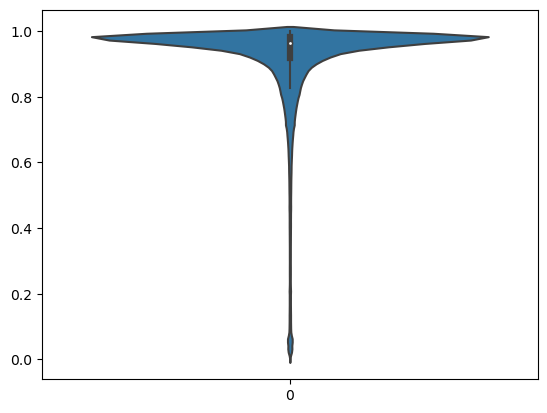

In [37]:
seaborn.violinplot(read_to_percent_coverage_by_top_transcript_array)

In [38]:
read_to_top_coverage_and_transcripts["m64220e_221031_034831/249/ccs"]

(2200, ['ENSMUST00000003572'])

In [39]:
len(id_to_seq["m64220e_221031_034831/249/ccs"])

2376

In [40]:
np.median(read_to_percent_coverage_by_top_transcript_array)

0.9636767976278725

In [41]:
for (read_name, ratio) in read_to_percent_coverage_by_top_transcript.items():
    if ratio > 1.0:
        print(read_name, ratio, len(id_to_seq[read_name]), read_to_top_coverage_and_transcripts[read_name])

In [42]:
match_locs["m64220e_221031_034831/198186/ccs"]

[('AGTTCCGTGGAGACTGCGAGTTCCGTCTGCTGTGTGAGGACTGCCGCCAC',
  [(Transcript(transcript_id='ENSMUST00000136312', transcript_name='Ubc-202', gene_id='ENSMUSG00000008348', biotype='protein_coding', contig='5', start=125463029, end=125467078, strand='-', genome='GRCm39'),
    260)]),
 ('CACCGCTGACGATGCAGATCTTTGTGAAAACCTTAACTGGTAAGACCATC',
  [(Transcript(transcript_id='ENSMUST00000136312', transcript_name='Ubc-202', gene_id='ENSMUSG00000008348', biotype='protein_coding', contig='5', start=125463029, end=125467078, strand='-', genome='GRCm39'),
    310)]),
 ('ACCCTGGAGGTCGAGCCCAGTGACACCATTGAGAATGTCAAGGCAAAGAT',
  [(Transcript(transcript_id='ENSMUST00000156249', transcript_name='Ubc-203', gene_id='ENSMUSG00000008348', biotype='protein_coding', contig='5', start=125463041, end=125467266, strand='-', genome='GRCm39'),
    335),
   (Transcript(transcript_id='ENSMUST00000156249', transcript_name='Ubc-203', gene_id='ENSMUSG00000008348', biotype='protein_coding', contig='5', start=125463041, end=1254672

In [43]:
counts = defaultdict(Counter)

for t in genome.transcripts():
    if t.is_protein_coding and t.contains_start_codon:
        s = t.sequence
        offset = min(t.start_codon_spliced_offsets)
        upstream, start, downstream = s[offset-3:offset], s[offset:offset+3], s[offset+3:offset+4]
        counts["upstream"][upstream] += 1
        counts["start"][start] += 1
        counts["downstream"][downstream] += 1
        if downstream == "":
            print(t.id, t.start_codon_positions, t.start_codon_spliced_offsets, upstream, start, downstream)
            
                

ENSMUST00000140136 [59447418, 59447419, 59447420] [418, 419, 420] GTC ATG 
ENSMUST00000142898 [106742472, 106742473, 106742474] [419, 420, 421] GGA ATG 
ENSMUST00000144623 [100994674, 100994675, 100994676] [388, 389, 390] GAC ATG 
ENSMUST00000200933 [100834206, 100834207, 100834208] [287, 288, 289] AAG ATG 
ENSMUST00000201484 [100834206, 100834207, 100834208] [680, 681, 682] AAG ATG 
ENSMUST00000202071 [100834206, 100834207, 100834208] [319, 320, 321] AAG ATG 
ENSMUST00000202527 [100834206, 100834207, 100834208] [530, 531, 532] AAG ATG 
ENSMUST00000221646 [69836926, 69836927, 69836928] [462, 463, 464] GTA ATG 


In [44]:
counts["start"].most_common()

[('ATG', 53978),
 ('CTG', 52),
 ('TTG', 5),
 ('GTG', 1),
 ('ATA', 1),
 ('ATT', 1),
 ('ATC', 1)]

In [45]:
counts["upstream"].most_common()

[('GCC', 5007),
 ('ACC', 4718),
 ('AAG', 3832),
 ('', 3208),
 ('AGG', 2334),
 ('AAA', 2073),
 ('AGC', 1980),
 ('ATC', 1784),
 ('AAC', 1681),
 ('GAG', 1667),
 ('GAC', 1586),
 ('AGA', 1328),
 ('ACA', 1207),
 ('GAA', 1154),
 ('GTC', 1139),
 ('GCG', 1097),
 ('GGG', 1020),
 ('GGC', 976),
 ('CCC', 855),
 ('GCA', 811),
 ('GCT', 798),
 ('GTG', 780),
 ('CAG', 758),
 ('TCC', 726),
 ('ACT', 708),
 ('ACG', 659),
 ('CTC', 615),
 ('AAT', 551),
 ('GGA', 546),
 ('CTG', 520),
 ('ATA', 440),
 ('TTC', 437),
 ('AGT', 388),
 ('CCA', 373),
 ('TGG', 360),
 ('CAC', 359),
 ('GAT', 352),
 ('TCA', 320),
 ('CAA', 310),
 ('ATT', 306),
 ('CTT', 273),
 ('CCG', 271),
 ('TAA', 266),
 ('CGG', 252),
 ('GTT', 243),
 ('TTG', 232),
 ('TGA', 228),
 ('TCT', 205),
 ('TGC', 204),
 ('GTA', 198),
 ('CCT', 180),
 ('TAC', 180),
 ('CGC', 178),
 ('GGT', 175),
 ('TAG', 169),
 ('CTA', 153),
 ('TTT', 142),
 ('CGA', 125),
 ('TGT', 107),
 ('CAT', 105),
 ('ATG', 100),
 ('TTA', 93),
 ('TAT', 81),
 ('TCG', 70),
 ('CGT', 46)]

In [46]:
(counts["upstream"].most_common()[1][1] + counts["upstream"].most_common()[2][1])  / sum(counts["upstream"].values())

0.1582190640093266

In [47]:
unexplained = set()
for name, matches in match_locs.items():
    
    if (len(matches) * 50 / len(id_to_seq[name])) < 0.1:
        unexplained.add(name)

In [48]:
len(unexplained)

32256

In [49]:
codon_table = {
    'AAA': 'K', 'AAC': 'N', 'AAG': 'K', 'AAT': 'N', 'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
    'AGA': 'R', 'AGC': 'S', 'AGG': 'R', 'AGT': 'S', 'ATA': 'I', 'ATC': 'I', 'ATG': 'M', 'ATT': 'I',
    'CAA': 'Q', 'CAC': 'H', 'CAG': 'Q', 'CAT': 'H', 'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
    'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R', 'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
    'GAA': 'E', 'GAC': 'D', 'GAG': 'E', 'GAT': 'D', 'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
    'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G', 'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
    'TAA': '*', 'TAC': 'Y', 'TAG': '*', 'TAT': 'Y', 'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
    'TGA': '*', 'TGC': 'C', 'TGG': 'W', 'TGT': 'C', 'TTA': 'L', 'TTC': 'F', 'TTG': 'L', 'TTT': 'F',
    'NNN': 'X'
}

def translate_dna_codon(codon):
    return codon_table.get(codon.upper(), 'X')

def find_start_codons(sequence):
    start_codon = "ATG"
    start_positions = [
        i for i in range(len(sequence)) 
        if sequence[i:i+3] == start_codon
        and sequence[i+3:i+4] in  {"G", "A"}
    ]
    return start_positions

def translate(sequence, start_positions=None):
    if start_positions is None:
        start_positions = [0]
    
    longest_orf = ""
    
    for start_pos in start_positions:
        translated_seq = ""

        for i in range(start_pos, len(sequence), 3):
            codon = sequence[i:i+3]
            if len(codon) < 3:
                break

            amino_acid = translate_dna_codon(codon)
            if amino_acid == '*':  # Stop codon
                break

            translated_seq += amino_acid

        if len(translated_seq) > len(longest_orf):
            longest_orf = translated_seq

    return longest_orf


def find_longest_orf(sequence):
    return translate(sequence, start_positions = find_start_codons(sequence))
    

aa_seq_to_reads = defaultdict(set)
for name in unexplained:
    nt_seq = id_to_seq[name]
    aa_seq = find_longest_orf(nt_seq)
    aa_seq_to_reads[aa_seq].add(name)
    
aa_seq_to_counts = Counter({aa_seq: len(read_names) for (aa_seq, read_names) in aa_seq_to_reads.items()})


In [50]:
long_aa_seq_to_counts = Counter({aa_seq: len(read_names) for (aa_seq, read_names) in aa_seq_to_reads.items() 
                                 if len(aa_seq) > 50})
long_aa_seq_to_counts.most_common(30)

[('MSFDPRALCASMLLLYFDPRALVCVLSCCCLIKSCLLHFMYGLSVFLGTRLSRDLSV', 362),
 ('MSFDPRALCAFCCCFISTPELWSVCFHVAALLNLTFYILCMVSVSSWVRGCPGT', 126),
 ('MGSSALALQTQSYQSLRAAIDADIVEMENSISKLQESLTLLSEVVLQNRRGLDLLFLQQDLCAALKEECCFYIDHSGVVKDSMAKVRKGLAKRKRERKQNQGWFNLGLTLSPWLHDPDFYPSGTIANPDVAFNFCSLHFKLLASFY',
  104),
 ('MNVLCFVLDNKDGIKNFICKAESHVFQPGIRHVARGPLLEKLFVLGNKGECTASKFQSKKASKWFMINVFDNGKVFFIFMVVATKIIIL',
  103),
 ('MTTLQSFCMKSIIPMCLRGPMWVGTSVIQVTASDADNPTYGKSAKLVYSILEGQPYFSVEAQTGIIRTALPNMDREAKEEYHVVIQAKDMGGHMGGLSGTTRVTITLTDVNDNSAKFPQSKESKLVFDNDHCSARASSFLSLLIYPAFKRKSLEIQESFS',
  96),
 ('MNARLSARSATSDFISSGEFVARLECVQKEVSPGGCRERCLDCADATMNQLIGSIEKGVVPGPQVPKLARRAVVGEVSLSMKVVSELCC',
  84),
 ('MTWGVVSKAFPSLGSSGLGLERCILGHSQGLQVGKTCSSLGQIVTLFSVCCPFRLVSRMLFEG', 67),
 ('MTTLQSFCVKSIIPMCLRGPMWVGTSVIQVTASDADNPTYGKSAKLVYSILEGQPYFSVEAQTGIIRTALPNMDREAKEEYHVVIQAKDMGGHMGGLSGTTRVTITLTDVNDNSAKFPKSKESKLVFDNDHCSARASSFLSLLIYPAFKRKSLEIQESFS',
  65),
 ('MESAVCTWHSAAYKSEAGPAENTSPVLKATCQGHSAGKLKPVQGRWAEIMWTVRKVHLVRKEGYSRYNPGMSCTGVW

In [51]:
s = """MKGDEVSITRREMLPSAPDGIKTPMTTIRFPKAKTLQILTLLISIGVVQTSPMPHEPHNLTWVITNTATGTVINSTSHLAPIGTWFPDLVFDLCALADGTWDPLGLVWGCQHPAQHSELRRTPFYVCPGEGRSPQQTATCGGPESYFCAYWGCESTGSISWTPPIKDDLIKVQRSPGSESQGWGYGLQPKLDANDLGGPCSSNCNPITVQFTPKGKESVGWEKGKTWGLRLYVSGYDYGVMFTIQLSARQGMPLGPNPALPPVGLTVTQSQITVPISQELRPRSGPWDLLKATYLVLNNSKPELTSKCWLCLDAQPPYYEGIAVPGNYTTSTDNKDCRWQYPGKGRLTLELIQGKGLCFGTIPHTHRHLCNSIQEAPDRDAYIIPPINTWWACTTGLTSCIHTQALNLTNGFCVLVQLAPRILRYSDEMGTRLSPFPAARAKRATVAEILGASAFDFQDENYKVLSSAIDADLMELGKSLSKSKTSLTSLREATLRNQREQDFQSLQQDGLCKPLEKRCCTFVDNLKHARELLAKVRKRLEDRKREMEQGQPVWITVIATLSGFLGLVILIVICKLYVVNPLMDSSRTRSPPSDTY"""

In [52]:
len(s)

596

In [53]:
aa_seq_to_reads["MSFDPRALCASMLLLYFDPRALVCVLSCCCLIKSCLLHFMYGLSVFLGTRLSRDLSV"]

{'m64220e_221031_034831/10029612/ccs',
 'm64220e_221031_034831/101713368/ccs',
 'm64220e_221031_034831/102106691/ccs',
 'm64220e_221031_034831/102237955/ccs',
 'm64220e_221031_034831/102237981/ccs',
 'm64220e_221031_034831/102762600/ccs',
 'm64220e_221031_034831/102828755/ccs',
 'm64220e_221031_034831/103088861/ccs',
 'm64220e_221031_034831/103351720/ccs',
 'm64220e_221031_034831/103874579/ccs',
 'm64220e_221031_034831/10488153/ccs',
 'm64220e_221031_034831/104990377/ccs',
 'm64220e_221031_034831/105121873/ccs',
 'm64220e_221031_034831/106103897/ccs',
 'm64220e_221031_034831/108790376/ccs',
 'm64220e_221031_034831/109447191/ccs',
 'm64220e_221031_034831/109643359/ccs',
 'm64220e_221031_034831/110757238/ccs',
 'm64220e_221031_034831/110888405/ccs',
 'm64220e_221031_034831/111018217/ccs',
 'm64220e_221031_034831/111608105/ccs',
 'm64220e_221031_034831/112264847/ccs',
 'm64220e_221031_034831/112855837/ccs',
 'm64220e_221031_034831/113312534/ccs',
 'm64220e_221031_034831/114492952/ccs',
 '

In [54]:
id_to_seq["m64220e_221031_034831/10029612/ccs"]

'GGTCGAGACTCCTCTACCCTGTGCTAAGGTGTATGAGTTTCGACCCCAGAGCTCTGTGTGCTTCCATGTTGCTGCTTTATTTCGACCCCAGAGCGCTGGTCTGTGTGCTTTCATGTTGCTGCCTTATTAAATCTTGCCTTCTACATTTTATGTATGGTCTCAGTGTCTTCTTGGGTACGCGGCTGTCCCGGGACTTGAGTGTCTGAGTGAGGGTCTTCCCTCGAGGGTCTTTCATTTGGTGCGTTGGCCGGGAAACAGCGCGACCACCCAGAGGTCCTAGACCCACTTAGAGGTAAGATTCTTTGTTCTGCTTTGGTCTGATGTCTGTGTTCTGATGTCTGTGTTCTGTTTCTAAGTTTGGTGCGATCGCAGTTTCAGTTTTGCGGACGCTCAGTGAGACCGCGCTCCGAGAGGGAGTGCGGGGTGGATAAGGATAGACGTGTCCAGGTGTCCACCGTCCGTTCGCCCTGGGAGACGTCCCAGGAGGAACAGGGGAGGATCAGGGACGCCTGGTGGACCCCTTTGAAGGCCAAGAGACCATTTGGGGTTGCGAGATCGTGGGTTAGAGTCCCACCTCGTGCCCAGTTGCGAGATCGTGGGTTCGAGTCCCACCTCGTGTTTTGTCACGGGATCGTGGGTTCGAGTCCCACCTCGTGTTTTGTCACGGGATCGTGGGTTCGAGTCCCACCTCGTGTTTTGTTGCGAGATCGTGGGTTCGAGTCCCACCTCGCGTCTGGTCACGGGATCGTGGGTTCGAGTCCCACCTCGTGCAGAGGGTCTCAATTGGCCGGCCTTAGAGAGGCCATCTGATTCTTCTGGTTTCTTTTTTGTCTTAGTCTCGTGTCCGCTCTTGTTGTGACTACTGTTTTTCTAAAAATGGGACAATCTGTGTCCACTCCCCTTTCTCTGACTCTGGTTCTGTCGCTTGGTAATTTTGTTTGTTTACGTTTGTTTTTGTGAGTCGTCTATGTTGTCTGTTACTATCTTGTTTTTGTTTGT

In [55]:
read_to_top_coverage_and_transcripts["m64220e_221031_034831/10029612/ccs"]

(50, ['ENSMUST00000215682', 'ENSMUST00000213774', 'ENSMUST00000214546'])

In [56]:

import progressbar

read_to_transcript_start_codon_offsets = defaultdict(dict)
transcript_id_to_transcript = {t.id: t for t in ts}
pbar = progressbar.ProgressBar()
for (read_name, (_, transcript_ids)) in pbar(read_to_top_coverage_and_transcripts.items()):
    results = read_to_transcript_start_codon_offsets[read_name]
    for transcript_id in transcript_ids:
        t = transcript_id_to_transcript[transcript_id]
        if t.complete:
            start_codon = min(t.start_codon_spliced_offsets)
            results[transcript_id] = start_codon

100% |#########################################################################################################################################################################################################|


In [57]:
read_to_transcript_start_codon_offsets["m64220e_221031_034831/10029612/ccs"]

{'ENSMUST00000215682': 133, 'ENSMUST00000214546': 251}

In [58]:
match_locs["m64220e_221031_034831/10029612/ccs"]

[('CCAGCTGTGAGAGCTGCACTCCCGTCTCTGCTCTAAAGTTCCCTCTTCTC',
  [(Transcript(transcript_id='ENSMUST00000213774', transcript_name='Or5m3b-201', gene_id='ENSMUSG00000045392', biotype='protein_coding', contig='2', start=85850977, end=85871776, strand='+', genome='GRCm39'),
    18),
   (Transcript(transcript_id='ENSMUST00000214546', transcript_name='Or5m3b-203', gene_id='ENSMUSG00000045392', biotype='protein_coding', contig='2', start=85850984, end=85873666, strand='+', genome='GRCm39'),
    11),
   (Transcript(transcript_id='ENSMUST00000215682', transcript_name='Or5m3b-204', gene_id='ENSMUSG00000045392', biotype='protein_coding', contig='2', start=85850984, end=85875152, strand='+', genome='GRCm39'),
    11)])]

In [59]:
read_to_start_locs = defaultdict(list)
pbar = progressbar.ProgressBar()
for (read_name, match_list) in pbar(match_locs.items()):
    start_codons = read_to_transcript_start_codon_offsets[read_name]
    for kmer, transcript_and_offset_list in match_list:
        filtered_sublist = [
            (kmer, transcript, offset)
            for (transcript, offset) in transcript_and_offset_list
            if transcript.id in start_codons
            and offset <= start_codons[transcript.id] < (offset + len(kmer))   
        ]
        if filtered_sublist:
            read_to_start_locs[read_name].extend(filtered_sublist)

100% |#########################################################################################################################################################################################################|


In [60]:
observed_start_codons = Counter()
pbar = progressbar.ProgressBar()
read_name_to_transcript_to_start_offset = defaultdict(dict)
for i, (read_name, starts) in enumerate(pbar(read_to_start_locs.items())):
    transcript_to_start_codon_offset = read_to_transcript_start_codon_offsets[read_name]
    for (kmer, transcript, kmer_offset_in_transcript) in starts:
        start_codon_offset = transcript_to_start_codon_offset[transcript.id]
        read_seq = id_to_seq[read_name]
        kmer_match_start_on_read = read_seq.index(kmer)
        
        assert kmer_offset_in_transcript <= start_codon_offset
        offset_into_kmer_of_start = start_codon_offset - kmer_offset_in_transcript
        coding_seq_offset_on_read = kmer_match_start_on_read + offset_into_kmer_of_start
        # coding_sequence = read_seq[coding_seq_offset_on_read:]
        observed_start_codons[read_seq[coding_seq_offset_on_read:coding_seq_offset_on_read+3]] += 1
        read_name_to_transcript_to_start_offset[read_name][transcript.id] = coding_seq_offset_on_read
       

100% |#########################################################################################################################################################################################################|


In [61]:
read_name_to_transcript_to_coding_sequence = defaultdict(dict)
read_name_to_transcript_to_protein_sequence = defaultdict(dict)
pbar = progressbar.ProgressBar()
for i, (read_name, transcript_to_start_offset) in enumerate(pbar(read_name_to_transcript_to_start_offset.items())):
    for (transcript_id, start_offset) in transcript_to_start_offset.items():
        coding_sequence = id_to_seq[read_name][start_offset:]
        protein_sequence = translate(coding_sequence)
        read_name_to_transcript_to_coding_sequence[read_name][transcript_id] = coding_sequence
        read_name_to_transcript_to_protein_sequence[read_name][transcript_id] = protein_sequence

100% |#########################################################################################################################################################################################################|


In [62]:
observed_start_codons.most_common(20)

[('ATG', 3566503),
 ('CTG', 8004),
 ('GTG', 2600),
 ('ATA', 212),
 ('ATC', 156),
 ('AAT', 84),
 ('ATT', 56),
 ('AAG', 7),
 ('AGA', 4),
 ('ACT', 4),
 ('AGT', 2),
 ('CCT', 2),
 ('AGG', 1),
 ('CTT', 1),
 ('AGC', 1),
 ('ACG', 1)]

In [63]:
len(read_name_to_transcript_to_protein_sequence)

3328155

In [64]:

read_name_to_transcript_to_protein_sequence[]

SyntaxError: invalid syntax (3385612038.py, line 1)

In [ ]:
seaborn.histplot(np.array(list(lengths.values())))

In [ ]:
read_name_to_transcript_to_protein_sequence["m64220e_221031_034831/10029612/ccs"]

In [ ]:
read_name_to_longest_protein = {}
read_name_to_longest_protein_transcript = {}
for (read_name, transcript_to_protein) in read_name_to_transcript_to_protein_sequence.items():
    longest_protein = ""
    longest_protein_transcript = None
    for (t, p) in transcript_to_protein.items():
        if len(p) > len(longest_protein):
            longest_protein = p
            longest_protein_transcript = t
    if longest_protein:
        read_name_to_longest_protein[read_name] = longest_protein
        read_name_to_longest_protein_transcript[read_name] = longest_protein_transcript

In [ ]:
data = defaultdict(list)
pbar = progressbar.ProgressBar()
for (read_name, p) in pbar(read_name_to_longest_protein.items()):
    tid = read_name_to_longest_protein_transcript[read_name]
    t = transcript_id_to_transcript[tid]
    data["read_name"].append(read_name)
    
    data["transcript_id"].append(tid)
    data["transcript_name"].append(t.name)
    g = t.gene
    data["gene_id"].append(g.id)
    data["gene_name"].append(g.name)
    pr = t.protein_sequence
    data["reference_protein"].append(pr)
    data["reference_protein_length"].append(len(pr))
    
    data["read_protein"].append(p)
    data["read_protein_length"].append(len(p))
    


import pandas
df = pandas.DataFrame(data)


In [ ]:
df["read_cdna"] = [id_to_seq[read_name] for read_name in df.read_name]

In [ ]:
df["read_start_offset"] = [
    read_name_to_transcript_to_start_offset[read_name][transcript_id]
    for (read_name, transcript_id) in 
    zip(df.read_name, df.transcript_id)
]

In [ ]:
axes = seaborn.histplot(
    data=df[df.reference_protein_length < 5500], 
    x="reference_protein_length", 
    y="read_protein_length", bins=50,     cbar=True, cbar_kws=dict(shrink=.75), stat="percent")

In [ ]:
axes.figure.savefig("protein-length-read-vs-reference.png")

In [ ]:
().mean()

In [ ]:
(df["gene_name"].value_counts() > 20).sum()

In [ ]:
same = (df["read_protein"] == df["reference_protein"])
different = ~same 
df_different = df[different]

In [ ]:
df_different_and_longer = df_different[df_different.reference_protein_length < df_different.read_protein_length]

In [ ]:
df_different_and_longer.gene_name.value_counts()

In [ ]:
s1 = "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLDVEPS                                                                            VTTKKVKQEDRRTFLTTVSKKSPPCACSWV"
s2 = "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLDVEPSVTTKKVKQEDRRTFLTTVSKKSPPCACSWV"

In [ ]:
len("DTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLDVEPS")

In [ ]:
76 * 3


In [ ]:
row.transcript_id

In [ ]:
(df_different_and_longer.gene_name.value_counts() > 20).sum()

In [ ]:
much_longer = (df_different_and_longer.read_protein_length - df_different_and_longer.reference_protein_length) > 10

In [ ]:
df_much_longer = df_different_and_longer[much_longer]

In [ ]:
len(df_much_longer)

In [ ]:
vc = df_much_longer.gene_name.value_counts()

In [ ]:
vc[vc > 20]

In [ ]:
df_much_longer.to_csv('much-longer-read-proteins-than-reference-min-20-reads.csv')

In [ ]:
df_much_longer

In [ ]:
len(df_much_longer.gene_id.unique())

In [ ]:
data_list = []
for (gene_id, group) in df_much_longer.groupby("transcript_id"):
    top_group = []
    top_prot_seq = None
    for prot_seq, sub_group in group.groupby("read_protein"):
        if len(sub_group) > len(top_group):
            top_group = sub_group
            top_prot_seq = prot_seq
    sub_df = top_group.iloc[0].copy()
    del sub_df["read_name"]
    sub_df["read_names"] = ";".join(list(top_group.read_name))
    sub_df["num_reads"] = len(top_group)
    data_list.append(sub_df)
df_flat = pd.DataFrame(data_list);
df_flat

In [ ]:

import pandas as pd; 
df_exacto = pd.read_csv(
    "/Users/iskander/Downloads/much-longer-read-proteins-than-reference_structural_variants.tsv",
    sep="\t")

In [ ]:
df_exacto["pos_1_annotation_gene_id"]

In [ ]:
df_merge = pd.merge(df_exacto, df_flat, left_on="pos_1_annotation_gene_id", right_on="gene_id")

In [ ]:
len(df_merge)

In [ ]:
df_merge[df_merge.num_reads > 10]

In [ ]:
row = df_merge[df_merge.variant_id == "variant_9255"].iloc[0]

In [ ]:
row


In [ ]:
row.reference_protein

In [ ]:
row.read_protein

In [ ]:
"MASIWVGPRGTIKDYPGFSPSVDAEAIRKAIRGLGTDEKTLINILTERSNAQRQLIVKQYQAAYEQELKDDLKGDLSGHFEHVMVALVTAPALFDAKQLKKSMKGTGTDEDALIEILTTRSSRQMKEISQAYYTVYKKSLGDDISSETSGDFRKALLTLAD                                  GRRDESLKVDEHLAKKDAQILYNAGENKWGTDEDKFTEVLCLRSFPQLKLTFDEYRNISQKDIEDSIKGELSGHFEDLLLAIVHCARNTPAFLAERLHQALKGAGTDEFTLNRIMVSRSEIDLLDIRHEFKKHYGYSLYSAIQSDTSGDYRTVLLKICGEDD"
"MASIWVGPRGTIKDYPGFSPSVDAEAIRKAIRGLGTDEKTLINILTERSNAQRQLIVKQYQAAYEQELKDDLKGDLSGHFEHVMVALVTAPALFDAKQLKKSMKGTGTDEDALIEILTTRSSRQMKEISQAYYTVYKKSLGDDISSETSGDFRKALLTLADRTWRLQIVYPATLTDYRWQRQTQNQESLIFLCYIGRRDESLKVDEHLAKKDAQILYNAGENKWGTDEDKFTEVLCLRSFPQLKLTFDEYRNISQKDIEDSIKGELSGHFEDLLLAIVHCARNTPAFLAERLHQALKGAGTDEFTLNRIMVSRSEIDLLDIRHEFKKHYGYSLYSAIQSDTSGDYRTVLLKICGEDD"



In [ ]:
sub = df_merge[df_merge.gene_name == "Anxa3"]

In [ ]:
sub.ref

In [ ]:
sub.alt

In [ ]:
sub.pos_1_annotation_chrom


In [ ]:
r1 = df_merge[df_merge.num_reads > 4].iloc[0]

In [ ]:
r1

In [ ]:
r1.gene_name

In [ ]:
r1.read_protein


In [ ]:
r1.reference_protein

In [ ]:
"MVGVKPVGSDPDFQPELSGAGSRLAVVKFTMRGCGPCLRIAPAFSSMSNKYPQAVFLEVDVHQCQGTAATNNISATPTFLFFRNKVRIDQYQGADAVGLEEKIKQHLENDPGSNEDADIPKGYMDLMPFINKAGCECLNESDEHGFDNCLRKDMSFLESDCDEQLLITVAFNQPVKLYSMKFQGPDNGQGPKYVKIFINLPRSMDFEEAERSEPTQALELTEDDIKEDGIVPLRYVKFQNVNSVTLFVQSNQGEEETTRISYFTFIGTPVQATNMNDFKRVVGKKGESH"
"MVGVKPVGSDPDFQPELSGAGSRLAVVKFTMRGCGPCLRIAPAFSSMSNKYPQAVFLEVDVHQCQGTAATNNISATPTFLFFRNKVRIDQYQGADAVGLEEKIKQHLENDPGSNEDADIPKGYMDLMPFINKAGCECLNESDEHGFDNCLRKDMSFLESDCDEQLLITVAFNQPVKLYSMKFQGPDNGQGPKYVKIFINLPRSMDFEEAERSEPTQALELTEDDIKEDGIVPLRYVKFQNVNSVTLFVQSNQGEEETTRISYFTFIGTPVQATNMNDFKRVVGKKRGKPLGYKDTGRLTAVRLAAPG"


In [ ]:

r2 = df_merge[df_merge.num_reads > 4].iloc[1]

In [ ]:
r2.read_protein


In [ ]:
r2.reference_protein

In [ ]:
s1 = "MASIWVGPRGTIKDYPGFSPSVDAEAIRKAIRGLGTDEKTLINILTERSNAQRQLIVKQYQAAYEQELKDDLKGDLSGHFEHVMVALVTAPALFDAKQLKKSMKGTGTDEDALIEILTTRSSRQMKEISQAYYTVYKKSLGDDISSETSGDFRKALLTLADRTWRLQIVYPATLTDYRWQRQTQNQESLIFLCYIGRRDESLKVDEHLAKKDAQILYNAGENKWGTDEDKFTEVLCLRSFPQLKLTFDEYRNISQKDIEDSIKGELSGHFEDLLLAIVHCARNTPAFLAERLHQALKGAGTDEFTLNRIMVSRSEIDLLDIRHEFKKHYGYSLYSAIQSDTSGDYRTVLLKICGEDD"
s2 = "MASIWVGPRGTIKDYPGFSPSVDAEAIRKAIRGLGTDEKTLINILTERSNAQRQLIVKQYQAAYEQELKDDLKGDLSGHFEHVMVALVTAPALFDAKQLKKSMKGTGTDEDALIEILTTRSSRQMKEISQAYYTVYKKSLGDDISSETSGDFRKALLTLAD----------------------------------GRRDESLKVDEHLAKKDAQILYNAGENKWGTDEDKFTEVLCLRSFPQLKLTFDEYRNISQKDIEDSIKGELSGHFEDLLLAIVHCARNTPAFLAERLHQALKGAGTDEFTLNRIMVSRSEIDLLDIRHEFKKHYGYSLYSAIQSDTSGDYRTVLLKICGEDD"

In [ ]:
s2.index("-")

In [ ]:
r2.transcript_id

In [ ]:
len(s1)

In [ ]:
len(s2)

In [ ]:
t = transcript_id_to_transcript[r2.transcript_id]

In [ ]:
lens = [len(e) for e in t.exons]

In [ ]:
lens

In [ ]:
def cumsum(xs):
    res = []
    for x in xs:
        if not res:
            res.append(x)
        else:
            res.append(x + res[-1])
    return res 

In [ ]:
cumsum(lens)

In [ ]:
read_to

In [ ]:
df.columns

In [ ]:
df.to_csv("protein-sequences-from-reads.csv")

In [ ]:
c = Counter()
transcript_id_to_df_group = {}
for transcript_id, group in df.groupby("transcript_id"):
    c[transcript_id] = len(group) 
    transcript_id_to_df_group[transcript_id] = group

In [ ]:
c.most_common()

In [ ]:
subdf = transcript_id_to_df_group["ENSMUST00000034834"]

In [ ]:
(subdf.read_protein == subdf.reference_protein).mean()

In [ ]:
k = 50
kmer_counts = Counter()
kmer_neighbors = {}
pbar = progressbar.ProgressBar()
for read_seq in pbar(transcript_id_to_df_group["ENSMUST00000034834"].read_cdna):
    for i in range(0, len(read_seq) - k + 1):
        kmer = read_seq[i:i+k]
        kmer_counts[kmer] += 1
        for j in range(k):
            for nt in "ACTG":
                other = kmer[:j] + nt + kmer[j:-1]
                kmer_neighbors[other] = kmer
                

In [ ]:
c = Counter()
len_counts = Counter()
len_groups = defaultdict(list)
for cdna in transcript_id_to_df_group["ENSMUST00000034834"].read_cdna:
    c[cdna] += 1
    len_counts[len(cdna)] += 1
    len_groups[len(cdna)].append(cdna)
print(c.most_common(1))


In [ ]:
len(transcript_id_to_df_group["ENSMUST00000034834"].read_cdna)

In [ ]:
len_counts.most_common()

In [ ]:
read_name_to_array = {}
pbar = progressbar.ProgressBar()

for read_name, read_seq in pbar(id_to_seq.items()):
    read_name_to_array[read_name] = np.array(list(map(ord, read_seq)))


In [ ]:
most_common_seq = 'GCACAGCAGCGACTCGTCTTCACTTGACTGACGTCCGCTCTAGGTATCGCAGCAGGAACCGAAGTACGCCCGAGGACTTCAGGAACCATGCCGAAGCCACACAGTGAAGCAGGGACTGCCTTCATTCAGACCCAGCAGCTCCATGCAGCCATGGCTGACACCTTCCTGGAACACATGTGCCGCCTGGACATTGACTCTGCCCCCATCACGGCCCGCAACACTGGCATCATTTGTACCATTGGGCCTGCTTCCCGATCTGTGGAGATGCTGAAGGAGATGATTAAGTCTGGAATGAATGTGGCTCGGCTGAATTTCTCTCATGGAACCCATGAGTACCATGCAGAGACCATCAAGAATGTCCGTGAAGCCACAGAAAGCTTTGCATCTGATCCCATTCTCTACCGTCCTGTTGCGGTGGCTCTGGATACAAAGGGACCTGAGATCCGGACTGGACTCATCAAGGGCAGCGGCACCGCTGAGGTGGAGCTGAAGAAGGGAGCCACTCTGAAGATCACCCTGGACAACGCTTACATGGAGAAGTGTGACGAGAACATCCTGTGGCTGGACTACAAGAACATCTGCAAGGTGGTGGAGGTGGGCAGCAAGATCTACGTGGACGATGGGCTCATCTCACTGCAGGTGAAGGAGAAAGGCGCTGACTTCCTGGTGACGGAGGTGGAGAATGGTGGCTCCTTGGGCAGCAAGAAGGGCGTGAACCTGCCGGGCGCTGCTGTGGATCTCCCCGCTGTGTCGGAAAAGGACATCCAGGACCTGAAGTTTGGGGTGGAGCAGGATGTGGACATGGTGTTTGCATCTTTCATCCGCAAGGCAGCCGACGTGCATGAAGTCAGGAAGGTGCTGGGAGAGAAGGGCAAGAACATCAAGATCATCAGCAAAATCGAGAACCATGAAGGCGTCCGCAGGTTTGATGAGATCTTGGAGGCCAGTGATGGGATCATGGTGGCTCGTGGTGACCTGGGCATTGAGATTCCTGCAGAGAAGGTCTTCCTGGCTCAGAAGATGATGATCGGGCGATGCAACCGAGCTGGGAAGCCTGTCATCTGTGCCACACAGATGCTGGAGAGCATGATCAAGAAGCCACGCCCCACCCGTGCTGAAGGCAGTGATGTGGCCAATGCAGTCCTGGATGGAGCAGACTGCATCATGCTGTCTGGAGAAACAGCCAAGGGGGACTACCCTCTGGAGGCTGTTCGCATGCAGCACCTGATTGCCCGAGAGGCAGAGGCTGCCATCTACCACTTGCAGCTATTCGAGGAACTCCGCCGCCTGGCGCCCATTACCAGCGACCCCACAGAAGCTGCCGCCGTGGGTGCCGTGGAGGCCTCCTTCAAGTGCTGCAGTGGGGCCATTATCGTGCTCACCAAGTCTGGCAGGAGTGCTCACCAAGTGGCCAGGTACCGCCCTCGGGCTCCTATCATTGCCGTGACTCGAAATCCCCAGACTGCTCGCCAGGCCCATCTGTACCGTGGCATCTTCCCTGTGCTGTGTAAGGATGCCGTGCTGAATGCCTGGGCTGAGGATGTCGACCTTCGTGTAAACTTGGCCATGGATGTTGGCAAGGCCCGAGGCTTCTTCAAGAAGGGAGATGTGGTCATTGTGCTGACCGGGTGGCGCCCTGGCTCTGGATTCACCAACACCATGCGTGTAGTGCCTGTACCTTGATGGCCCTCTGGAGCCCCTCTTCTAGCCCCTGTCCCTTCCCCTCCCCTATCCTTTCCATTAGGCCAGCAACGCTTGTAGTGCTCACTCTGGGCCATAGTGTGGCGCTGGTGGGCTGGGACACCAGGGAAAATTAATGCCTCTAAAACATGCAATAGAGACCAGCTATTATTCAGGGCCCTACCTGAGCCAGGGGTGGAGGAGGAATGCAGGACTGGAAACCCTGACTTTATCACAGAAGGGCGGCAGCATCTCTGGGCTTTGCTTCTGTAGAAAGTTGTCAGAATTCCCAGCCCTAGCCTGGAGTCAGGAGACAGCAAAAGAGTAGGGGCTGAGGGTGTGGGGCCCAGGGTCCCAGTGTAGATGACGACTTCTGGCCCTGGCCCTGACCTGCTTTCCCAACAGCTTTGGCCTCCCCACTTCTTGTGCACTCCACTTCTGTCACTGCAGACACTCCACTCTCCACCTTGTATTCTGCAGAGTCTCCAGGCCTGTTGCTATAGTGCCCACCTGAATGTCAATAAACAGCAGCTGAAGC'
most_common_seq_array = np.array(list(map(ord, most_common_seq)), dtype="uint8")

subgroup = transcript_id_to_df_group["ENSMUST00000034834"]
read_name_to_best_offset = {}
read_name_to_best_identity_percent = {}
pbar = progressbar.ProgressBar()

def align_arrays(ref, query, align_left, query_trim, ref_trim):
    if ref_trim > 0:
        if align_left:
            ref = ref[ref_trim:]
        else:
            ref = most_common_seq_array[:-ref_trim]

    if query_trim > 0:
        if align_left:
            query = query[query_trim:]
        else:
            query = query[:-query_trim]

    if len(query) > len(ref):
        if align_left:
            query = query[:len(ref)]
        else:
            query = query[-len(ref):]

    elif len(ref) > len(query):
        if align_left:
            ref = ref[:len(query)]
        else:
            ref = ref[-len(query):]
    return (ref, query)

for read_name, read_seq in pbar(list(zip(subgroup.read_name, subgroup.read_cdna))):
    best_offset = None
    best_identity = 0
    read_seq_array = read_name_to_array[read_name]
    for align_left in [False, True]:
        for ref_trim in range(30):
            for query_trim in range(30):
                ref_subseq, read_subseq = align_arrays(
                    most_common_seq_array,
                    read_seq_array,
                    align_left,
                    ref_trim,
                    query_trim)

                identity = (read_subseq == ref_subseq).mean()
                if identity > best_identity:
                    best_offset = (align_left, ref_trim, query_trim)
                    best_identity = identity
                    # print(read_name, best_offset, best_identity)
                if best_identity == 1.0:
                    break
            if best_identity == 1.0:
                break 
        if best_identity == 1.0:
            break 
                
    read_name_to_best_offset[read_name] = best_offset
    read_name_to_best_identity_percent[read_name] = best_identity

In [ ]:
np.array(list(map(ord, most_common_seq)), dtype="uint8")

In [ ]:
for t in read_name_to_best_offset.values():
    print(t)

In [ ]:
ident_values = np.array(list(read_name_to_best_identity_percent.values()))

seaborn.histplot(ident_values)

In [ ]:
np.mean(ident_values == 1.0)

In [ ]:
np.min(ident_values)

In [ ]:
read_name_to_first_mismatch = {}
read_name_to_num_mismatches = {}
for (read_name, ident) in read_name_to_best_identity_percent.items():
    curr_template = most_common_seq_array
    if ident != 1.0:
        (align_left, ref_trim, query_trim) = read_name_to_best_offset[read_name]
        read_seq_array = read_name_to_array[read_name]
        ref, query = align_arrays(most_common_seq_array, read_seq_array, align_left, ref_trim, query_trim)
        mismatch = (ref != query)
        mismatch_idx = np.where(mismatch)[0]
        read_name_to_first_mismatch[read_name] = mismatch_idx[0]
        read_name_to_num_mismatches[read_name] = len(mismatch_idx)
    # else:
    #    read_name_to_first_mismatch[read_name] = -1
    #    read_name_to_num_mismatches[read_name] = 0


In [ ]:
mismatch_idx_values = np.array(list(read_name_to_first_mismatch.values()))

seaborn.histplot(mismatch_idx_values)

In [ ]:
{read_name for read_name, mismatch in read_name_to_first_mismatch.items() if mismatch > 1000}

In [ ]:
id_to_seq["m64220e_221031_034831/2163156/ccs"]

In [ ]:
read_name_to_first_mismatch["m64220e_221031_034831/2163156/ccs"]

In [ ]:
read_name_to_best_offset["m64220e_221031_034831/2163156/ccs"]

In [ ]:
s1 = most_common_seq[:-29]
s2 = id_to_seq["m64220e_221031_034831/2163156/ccs"][:-27]

In [ ]:
s1

In [ ]:
s2

In [ ]:
s2[1331-4:]

In [ ]:
s1[1331-4:]

In [ ]:
def homopolymer_